In [10]:
#!pip install opencv-python
#pip install numpy --upgrade
import skimage 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
%matplotlib inline
from skimage import color, data, exposure, feature, filters, measure, morphology, transform, util
import pandas as pd
import glob
import cv2
import tensorflow as tf

### Load Images

In [11]:
#Reading file according to order
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

images = [cv2.imread(file) for file in sorted(glob.glob("/Users/betulerkantarci/Downloads/archive-3/Source_Images/*.bmp"), key=numericalSort)]

In [12]:
len(images)

900

In [13]:
labels = []
a= 0
for i in range(len(images)):
    if(i<300):
        labels.append(1)
    elif(i>=300 and i<600):
        labels.append(2)
    else:
        labels.append(3)

In [14]:
data = {'Images': images, 'Labels': labels} 
df = pd.DataFrame(data)

In [15]:
print(df)

                                                Images  Labels
0    [[[142, 142, 142], [141, 141, 141], [141, 141,...       1
1    [[[132, 132, 132], [130, 130, 130], [133, 133,...       1
2    [[[110, 110, 110], [111, 111, 111], [109, 109,...       1
3    [[[139, 139, 139], [140, 140, 140], [137, 137,...       1
4    [[[137, 137, 137], [139, 139, 139], [137, 137,...       1
..                                                 ...     ...
895  [[[198, 198, 198], [190, 190, 190], [194, 194,...       3
896  [[[95, 95, 95], [99, 99, 99], [97, 97, 97], [9...       3
897  [[[109, 109, 109], [107, 107, 107], [107, 107,...       3
898  [[[104, 104, 104], [106, 106, 106], [104, 104,...       3
899  [[[152, 152, 152], [151, 151, 151], [165, 165,...       3

[900 rows x 2 columns]


In [16]:
print(images[0])

[[[142 142 142]
  [141 141 141]
  [141 141 141]
  ...
  [ 97  97  97]
  [ 99  99  99]
  [ 97  97  97]]

 [[147 147 147]
  [144 144 144]
  [145 145 145]
  ...
  [101 101 101]
  [101 101 101]
  [100 100 100]]

 [[149 149 149]
  [148 148 148]
  [141 141 141]
  ...
  [100 100 100]
  [ 98  98  98]
  [102 102 102]]

 ...

 [[132 132 132]
  [138 138 138]
  [133 133 133]
  ...
  [ 94  94  94]
  [ 95  95  95]
  [ 98  98  98]]

 [[133 133 133]
  [133 133 133]
  [134 134 134]
  ...
  [ 90  90  90]
  [ 96  96  96]
  [ 94  94  94]]

 [[133 133 133]
  [139 139 139]
  [133 133 133]
  ...
  [ 94  94  94]
  [ 95  95  95]
  [ 94  94  94]]]


In [17]:
kernel = np.ones((3, 3), np.float32) / 9

### Apply Mean Filtering

In [18]:
filteredImg = []
for i in images:
    filtered_image = cv2.filter2D(i, -1, kernel)
    filteredImg.append(filtered_image)

In [19]:
df['filteredImage'] = filteredImg

In [20]:
df

,Images,Labels,filteredImage
0,"[[[142, 142, 142], [141, 141, 141], [141, 141,...",1,"[[[144, 144, 144], [144, 144, 144], [141, 141,..."
1,"[[[132, 132, 132], [130, 130, 130], [133, 133,...",1,"[[[131, 131, 131], [132, 132, 132], [133, 133,..."
2,"[[[110, 110, 110], [111, 111, 111], [109, 109,...",1,"[[[110, 110, 110], [112, 112, 112], [112, 112,..."
3,"[[[139, 139, 139], [140, 140, 140], [137, 137,...",1,"[[[141, 141, 141], [140, 140, 140], [139, 139,..."
4,"[[[137, 137, 137], [139, 139, 139], [137, 137,...",1,"[[[136, 136, 136], [137, 137, 137], [138, 138,..."
...,...,...,...
895,"[[[198, 198, 198], [190, 190, 190], [194, 194,...",3,"[[[196, 196, 196], [197, 197, 197], [203, 203,..."
896,"[[[95, 95, 95], [99, 99, 99], [97, 97, 97], [9...",3,"[[[95, 95, 95], [95, 95, 95], [96, 96, 96], [9..."
897,"[[[109, 109, 109], [107, 107, 107], [107, 107,...",3,"[[[108, 108, 108], [108, 108, 108], [108, 108,..."
898,"[[[104, 104, 104], [106, 106, 106], [104, 104,...",3,"[[[105, 105, 105], [104, 104, 104], [103, 103,..."


### Detect Defect

In [27]:
def defect_detect(image):
    img = image.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    
    blr = cv2.blur(v, (15, 15))
    dst = cv2.fastNlMeansDenoising(blr, None, 10, 7,21)
    _,binary = cv2.threshold(dst, 127,255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = np.ones((5,5), np.uint8)
    erosion = cv2.erode(binary, kernel, iterations = 1)
    dilation = cv2.dilate(binary, kernel, iterations = 1)
    if (dilation==0).sum() > 1:
        print ("defective fabric")
        contours,_ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for i in contours:
            if cv2.contourArea(i) < 261121.0:
                cv2.drawContours(img, i, -1, (0,255,0), 3)
    else:
        print ("Good fabric")
        
    return image,hsv,v,blr,dst,binary,dilation,img

defective fabric


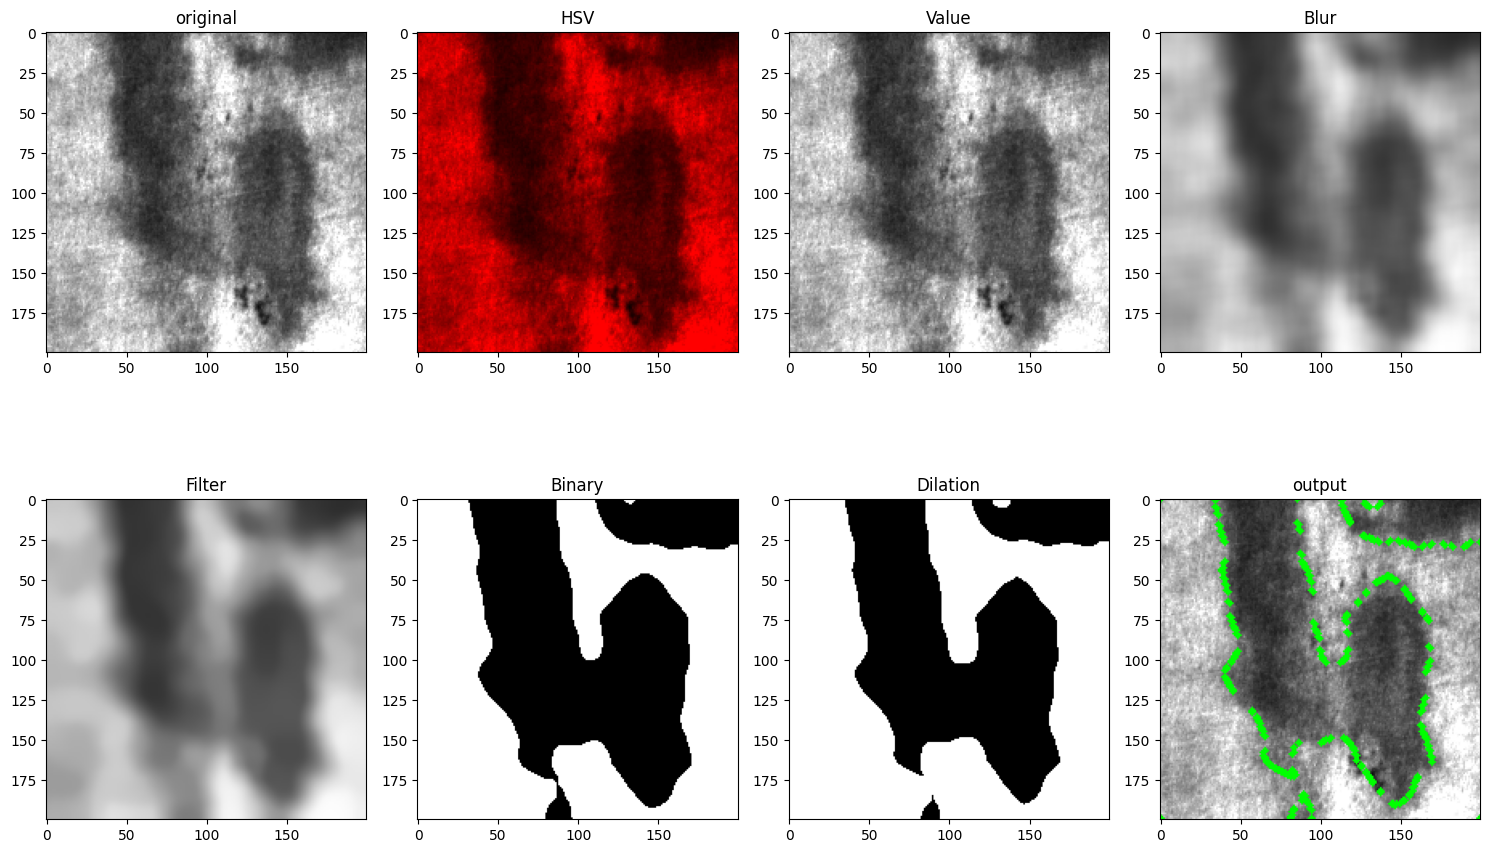

In [31]:
image,hsv,v,blr,dst,binary,dilation,img = defect_detect(images[301])

fig, ax = plt. subplots (2,4, figsize=(15, 10))
ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('original')
ax[0,1].imshow(cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB))
ax[0,1].set_title('HSV')
ax[0,2].imshow(cv2.cvtColor(v, cv2.COLOR_BGR2RGB))
ax[0,2].set_title('Value')
ax[0,3].imshow(cv2.cvtColor(blr, cv2.COLOR_BGR2RGB))
ax[0,3].set_title('Blur')
ax[1,0].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax[1,0].set_title('Filter')
ax[1,1].imshow(binary, cmap= 'gray')
ax[1,1].set_title('Binary')
ax[1,2].imshow(dilation, cmap='gray')
ax[1,2].set_title('Dilation')
ax[1,3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1,3].set_title('output')
fig.tight_layout ()

### Load images to different folders according to threshold combinations

In [ ]:
def defect_detect(image):
    img = image.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    
    blr = cv2.blur(v, (15, 15))
    dst = cv2.fastNlMeansDenoising(blr, None, 10, 7,21)
    _,binary = cv2.threshold(dst, 127,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #_,binary = cv2.threshold(dst, 127,255, cv2.THRESH_TRUNC + cv2.ADAPTIVE_THRESH_MEAN_C)
    #_,binary = cv2.threshold(dst, 127,255, cv2.THRESH_TOZERO + cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
    
    return binary

binaryImages = []
count=0
countIn=1
countPa=1
countSc=1
for i in filteredImg:
    binary = defect_detect(i)
    if(df['Labels'].iloc[count]==1):
        name = 'BO/In/' + 'In_' + str(countIn) + '.png' 
        countIn += 1
        plt.imsave(name, np.array(binary), cmap=cm.gray)
    elif(df['Labels'].iloc[count]==2):
        name = 'BO/Pa/' + 'Pa_' + str(countPa) + '.png' 
        countPa += 1
        plt.imsave(name, np.array(binary), cmap=cm.gray)
    else:
        name = 'BO/Sc/' + 'Sc_' + str(countSc) + '.png' 
        countSc += 1
        plt.imsave(name, np.array(binary), cmap=cm.gray)
    count+=1

#repeat for BO, TM, and ZG

### RESULTS

/var/folders/2h/_hcpdd4x2v330_j59w7lpb8r0000gn/T/ipykernel_9031/61661936.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(rect=[1, 1, 1, 1])


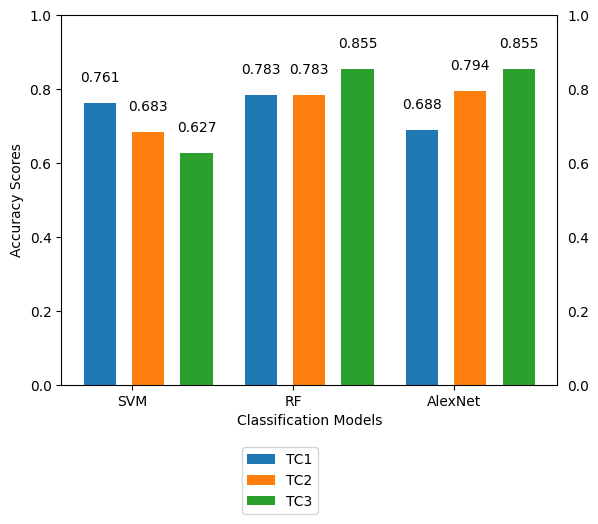

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the bars
types = ['SVM', 'RF', 'AlexNet']
bar_labels = ['TC1', 'TC2', 'TC3']

# Your specific array of values (replace this with your data)
data_values = np.array([
    [0.761, 0.683, 0.627],
    [0.783, 0.783, 0.855],
    [0.688, 0.794, 0.855]
])

# Set up the bar positions
bar_width = 0.2
bar_space=0.1
index = np.arange(len(types))

# Plotting the bars
fig, ax = plt.subplots()
for i, label in enumerate(bar_labels):
    bars = ax.bar(index + i * (bar_width + bar_space), data_values[:, i], bar_width, label=label)
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom') 
# Adding labels and title
ax.set_xlabel('Classification Models')
ax.set_ylabel('Accuracy Scores')
#ax.set_title('Bar graph of all models')

# Move the y-axis labels outside the plot
ax.tick_params(axis='y', labelright=True)

ax.set_xticks(index + (len(bar_labels) - 1) * bar_width / 2)
ax.set_xticklabels(types)
ax.set_ylim([0, 1])  # Set y-axis range from 0 to 1
ax.legend(bbox_to_anchor=(0.35, -0.15), loc='upper left')

# Adjust layout to make room for labels outside the plot
fig.tight_layout(rect=[1, 1, 1, 1])

# Show the plot
plt.show()